## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 CNN 1D 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.09.01.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. **1D-CNN을 통하여 classification한다.**

In [1]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-09-03 09:01:44.214074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# records 병합

import glob

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")

print (all_files)

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in all_files :
    df = pd.read_csv(filename)  
    df_list.append(df) 

merged_df = pd.concat(df_list, ignore_index=True) # 병합 (header는 ignore)
df = merged_df

df.head()

['../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S029.csv', '../../data/harth/S015.csv', '../../data/harth/S014.csv', '../../data/harth/S028.csv', '../../data/harth/S010.csv', '../../data/harth/S013.csv', '../../data/harth/S012.csv', '../../data/harth/S006.csv', '../../data/harth/S023.csv', '../../data/harth/S022.csv', '../../data/harth/S008.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S009.csv', '../../data/harth/S025.csv', '../../data/harth/S019.csv', '../../data/harth/S018.csv', '../../data/harth/S024.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,Unnamed: 0
0,2019-01-12 00:00:00.000,-0.982201,-0.031251,0.178300,-0.935149,0.006160,-0.358898,6,NaN,NaN
1,2019-01-12 00:00:00.020,-0.973421,-0.042747,0.190618,-0.934986,0.040489,-0.366376,6,NaN,NaN
2,2019-01-12 00:00:00.040,-0.977409,-0.033531,0.185584,-0.939761,0.028617,-0.370106,6,NaN,NaN
3,2019-01-12 00:00:00.060,-0.974620,-0.034506,0.188868,-0.939667,0.036060,-0.369624,6,NaN,NaN
4,2019-01-12 00:00:00.080,-0.976828,-0.041577,0.186524,-0.946145,0.030512,-0.363411,6,NaN,NaN


In [3]:
# timestamp, index 삭제, unnamed 삭제

try : 
    del df['timestamp']
    del df['index']
except : 
    pass

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print ("현재 attribute : ", df.columns)

현재 attribute :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [4]:
# df의 크기 및 info
print("df 크기 : ", df.shape)
df.info()

df 크기 :  (6461328, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   back_x   float64
 1   back_y   float64
 2   back_z   float64
 3   thigh_x  float64
 4   thigh_y  float64
 5   thigh_z  float64
 6   label    int64  
dtypes: float64(6), int64(1)
memory usage: 345.1 MB


In [5]:
# target의 class 도수를 확인 (숫자로)

df['label'].value_counts()

label
7      2902703
1      1197155
6       743480
8       428898
13      393963
2       291356
3       254839
4        76217
5        67253
14       55814
130      41785
140       7865
Name: count, dtype: int64

In [6]:
# # iterrows를 사용하여 각 행에 접근

# for index, row in df.iterrows() :
#     compo_label = df.at[index, 'label']
    
#     if compo_label == 13 :
#         df.at[index, 'label'] = 9
        
#     elif compo_label == 14 : 
#         df.at[index, 'label'] = 10
        
#     elif compo_label == 130 : 
#         df.at[index, 'label'] = 11
        
#     elif compo_label == 140 : 
#         df.at[index, 'label'] = 12

df['label'] = df['label'].replace({13: 9, 14: 10, 130: 11, 140: 12})

for_0_based = dict()
for i in range (12) : 
    for_0_based[i+1] = i
    
df['label'] = df['label'].replace(for_0_based)

# label 열의 고유값을 출력
print (df['label'].unique())


[ 5  2  0  6  1  7  4  3  8 10  9 11]


In [7]:
# input과 target으로 split

harth_input = df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].to_numpy() 
harth_target = df['label'].to_numpy()

# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# 또한, X_train, y_train, X_val, y_val로 train set, validation set 각각 8:2로 split

X_train, X_test, y_train, y_test = train_test_split(harth_input, harth_target, 
                                                   stratify=harth_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        test_size=0.2, 
                                                        stratify=y_train)

In [8]:
# StandardScaler을 통한 정규화 진행

ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

In [9]:
# X_train_scaled, X_test_scaled, X_val_scaled 데이터를 3차원 tensor로 전환한다.

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], 
                                           X_train_scaled.shape[1], 
                                           1))

X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], 
                                         X_test_scaled.shape[1], 
                                         1))

X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], 
                                       X_val_scaled.shape[1], 
                                       1))

X_train_cnn.shape, X_test_cnn.shape, X_val_cnn.shape

((4135249, 6, 1), (1292266, 6, 1), (1033813, 6, 1))

-------

### CNN (1D)
- convolution을 통하여 중요한 feature만 도드라지게 하여 학습을 진행한다.
- 아래와 같이 dataset을 구성한다.
    - tensor로 전환하여 Conv1D layer로 convolution을 시행할 수 있을 것 같다. 아래와 같이 전환한다.
        - 배치 크기 : row 갯수 (sample의 수)
        - 길이 : feature 수 (col 수)
        - 채널 : 1 (단일 채널)
    - 전환 후 CNN 1d를 적용하여 main feature extraction 후 pooling을 진행한다.
    - Conv, pooling을 2번 반복 후 dense layer를 두어 regression한다.
        - 중간에 dropout 층을 배치하여 overfitting을 막고 학습에 신중하도록 한다.
- 여기서는 poly set 대신 normal set을 사용하겠다.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,276 (36.23 KB)

 Trainable params: 9,212 (35.98 KB)

 Non-trainable params: 64 (256.00 B)

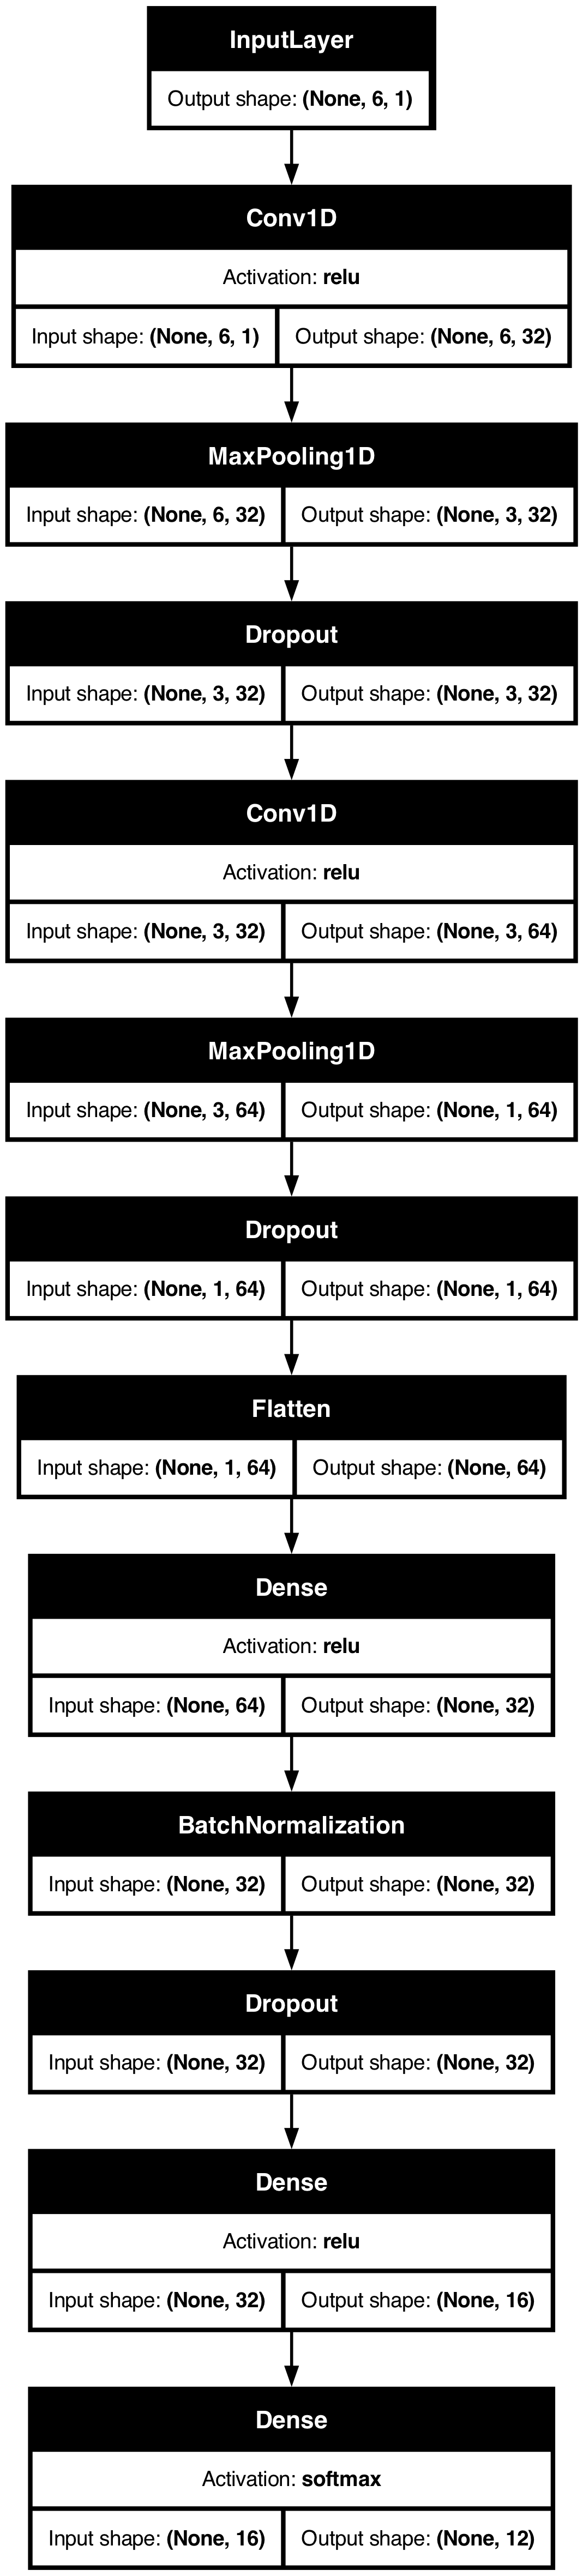

In [10]:
# modelling (functional API 방식)

# 입력 레이어
input_layer = keras.Input(shape=(X_train_scaled.shape[1], 1))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.4)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.4)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(32, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(16, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

# model = keras.Model(
#     input_layer,
#     conv_1,
#     pooling_1,
#     conv_2,
#     pooling_2,
#     flatten,
#     dense_1,
#     dropout_1,
#     dense_2,
#     dropout_2,
#     dense_3,
#     output_layer
# )

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [11]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, epochs=100, 
                    validation_data=(X_val_cnn, y_val), batch_size=512, 
                    callbacks=early_stopping_cb, 
                    verbose=True)

Epoch 1/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.7609 - loss: 0.7570 - val_accuracy: 0.8515 - val_loss: 0.4653
Epoch 2/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.8247 - loss: 0.5531 - val_accuracy: 0.8557 - val_loss: 0.4540
Epoch 3/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - accuracy: 0.8281 - loss: 0.5413 - val_accuracy: 0.8578 - val_loss: 0.4498
Epoch 4/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.8300 - loss: 0.5365 - val_accuracy: 0.8574 - val_loss: 0.4478
Epoch 5/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - accuracy: 0.8311 - loss: 0.5327 - val_accuracy: 0.8581 - val_loss: 0.4484
Epoch 6/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.8318 - loss: 0.5303 - val_accuracy: 0.8608 - val_loss: 0.4464
Epoch 7/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - accuracy: 0.8320 - loss: 0.5305 - val_accuracy: 0.8592 - val_loss: 0.4452
Epoch 8/100
8077/8077 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - accuracy: 0.8327 -

{'accuracy': [0.8015792965888977, 0.8260859251022339, 0.8287795782089233, 0.8303918242454529, 0.8310319185256958, 0.831836462020874, 0.8324161171913147, 0.8327203392982483, 0.8329271078109741, 0.8333427906036377, 0.8335577845573425, 0.8338322639465332, 0.8337889909744263, 0.8341799974441528], 'loss': [0.625935435295105, 0.5492939352989197, 0.5398077964782715, 0.535166323184967, 0.5327553153038025, 0.5307102203369141, 0.5290528535842896, 0.5278458595275879, 0.5269079208374023, 0.5262689590454102, 0.5250898599624634, 0.5249853730201721, 0.5242583155632019, 0.5233526825904846], 'val_accuracy': [0.8515108823776245, 0.8557301759719849, 0.857782781124115, 0.8573572039604187, 0.8581135869026184, 0.8607620596885681, 0.8592095375061035, 0.858412504196167, 0.8583022356033325, 0.8594833016395569, 0.8602861166000366, 0.8596718907356262, 0.8611006140708923, 0.8597386479377747], 'val_loss': [0.4653203785419464, 0.4540427625179291, 0.4498002529144287, 0.4477693736553192, 0.44842728972435, 0.446447759

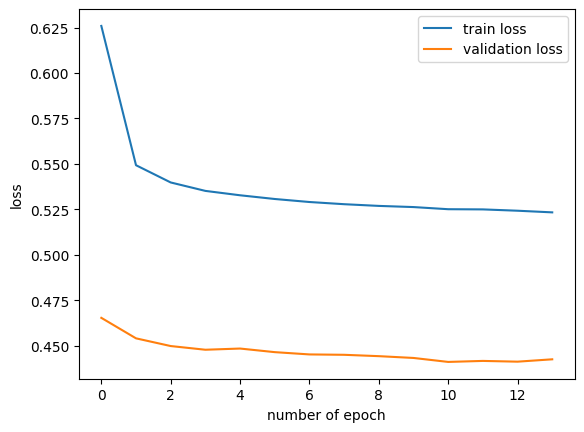

In [13]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [14]:
# evaluate

model.evaluate(X_val_cnn, y_val)

32307/32307 ━━━━━━━━━━━━━━━━━━━━ 18s 558us/step - accuracy: 0.8601 - loss: 0.4414


[0.4410671591758728, 0.8602861166000366]

In [15]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_cnn)
y_test_pred = model.predict(X_test_cnn)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

32307/32307 ━━━━━━━━━━━━━━━━━━━━ 19s 574us/step
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 23s 580us/step
- validation data confusion matrix -

[[160065   1874     61      0      0  23218    841     83   4897    506
       0      0]
 [ 12145  32636      2      0      0    170    535    586    342    201
       0      0]
 [ 12459     83    112      0      0  26345    352     33   1228    162
       0      0]
 [  8258    238      2      0      0   1353     68     21   2161     94
       0      0]
 [  9167    501      3      0      0    490     30     13    527     30
       0      0]
 [  6218    125    102      0      0 109913   1158     12   1269    160
       0      0]
 [   996     18      0      0      0    299 462122    144    844     10
       0      0]
 [    82     26      0      0      0      2    103  68397     11      3
       0      0]
 [  6768    196      0      0      0    950    960     31  53641    488
       0      0]
 [  2856    158      0      0      0    346     21     11   3049 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

- validation data report of classification -

              precision    recall  f1-score   support

           0       0.73      0.84      0.78    191545
           1       0.91      0.70      0.79     46617
           2       0.40      0.00      0.01     40774
           3       0.00      0.00      0.00     12195
           4       0.00      0.00      0.00     10761
           5       0.67      0.92      0.78    118957
           6       0.99      1.00      0.99    464433
           7       0.99      1.00      0.99     68624
           8       0.73      0.85      0.78     63034
           9       0.57      0.28      0.38      8930
          10       0.00      0.00      0.00      6685
          11       0.00      0.00      0.00      1258

    accuracy                           0.86   1033813
   macro avg       0.50      0.47      0.46   1033813
weighted avg       0.83      0.86      0.83   1033813


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- test data report of classification -

              precision    recall  f1-score   support

           0       0.73      0.83      0.78    239431
           1       0.91      0.70      0.79     58271
           2       0.46      0.00      0.01     50968
           3       0.00      0.00      0.00     15243
           4       0.00      0.00      0.00     13450
           5       0.67      0.93      0.78    148696
           6       0.99      1.00      0.99    580541
           7       0.99      1.00      0.99     85780
           8       0.73      0.85      0.78     78793
           9       0.57      0.28      0.38     11163
          10       0.00      0.00      0.00      8357
          11       0.00      0.00      0.00      1573

    accuracy                           0.86   1292266
   macro avg       0.50      0.47      0.46   1292266
weighted avg       0.83      0.86      0.83   1292266


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----

하지만, 위 결과를 잘 생각해보자. **CNN을 진행 시에 split_sequence로 순환형 데이터를 만들지 않고, 단지 df에서 reshape한 형태로만 학습을 진행했다.** 이는 그저 **DNN과 다름이 없을 뿐**이니, split_sequence 함수를 사용하여 데이터를 순환형으로 만든 후에 다시 학습을 진행한다. split_sequence를 아래와 같이 정의하자.

- split_sequence를 통하여 타임스텝을 stride 1씩 이동시키면서 데이터를 분할한다. 
- 결국에 classification할 것은, 각 시퀀스의 마지막 time step의 label일 것이다.

In [16]:
def split_sequence (sequences, n_steps) :
    X, y = [], [] 
    
    for i in range(len(sequences)) :
        end_ix = i + n_steps
        if end_ix > len(sequences)-1 :
            break
            
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [17]:
# sequential data로 변경 (여기서의 타임 스텝은 30으로)

n_steps = 30

X_train_seq, y_train_seq = split_sequence (np.column_stack((X_train_scaled, y_train)), n_steps)
X_test_seq, y_test_seq = split_sequence (np.column_stack((X_test_scaled, y_test)), n_steps)
X_val_seq, y_val_seq = split_sequence (np.column_stack((X_val_scaled, y_val)), n_steps)

X_train_seq.shape, X_test_seq.shape, X_val_seq.shape

((4135219, 30, 6), (1292236, 30, 6), (1033783, 30, 6))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 16)         │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,204 (12.52 KB)

 Trainable params: 3,172 (12.39 KB)

 Non-trainable params: 32 (128.00 B)

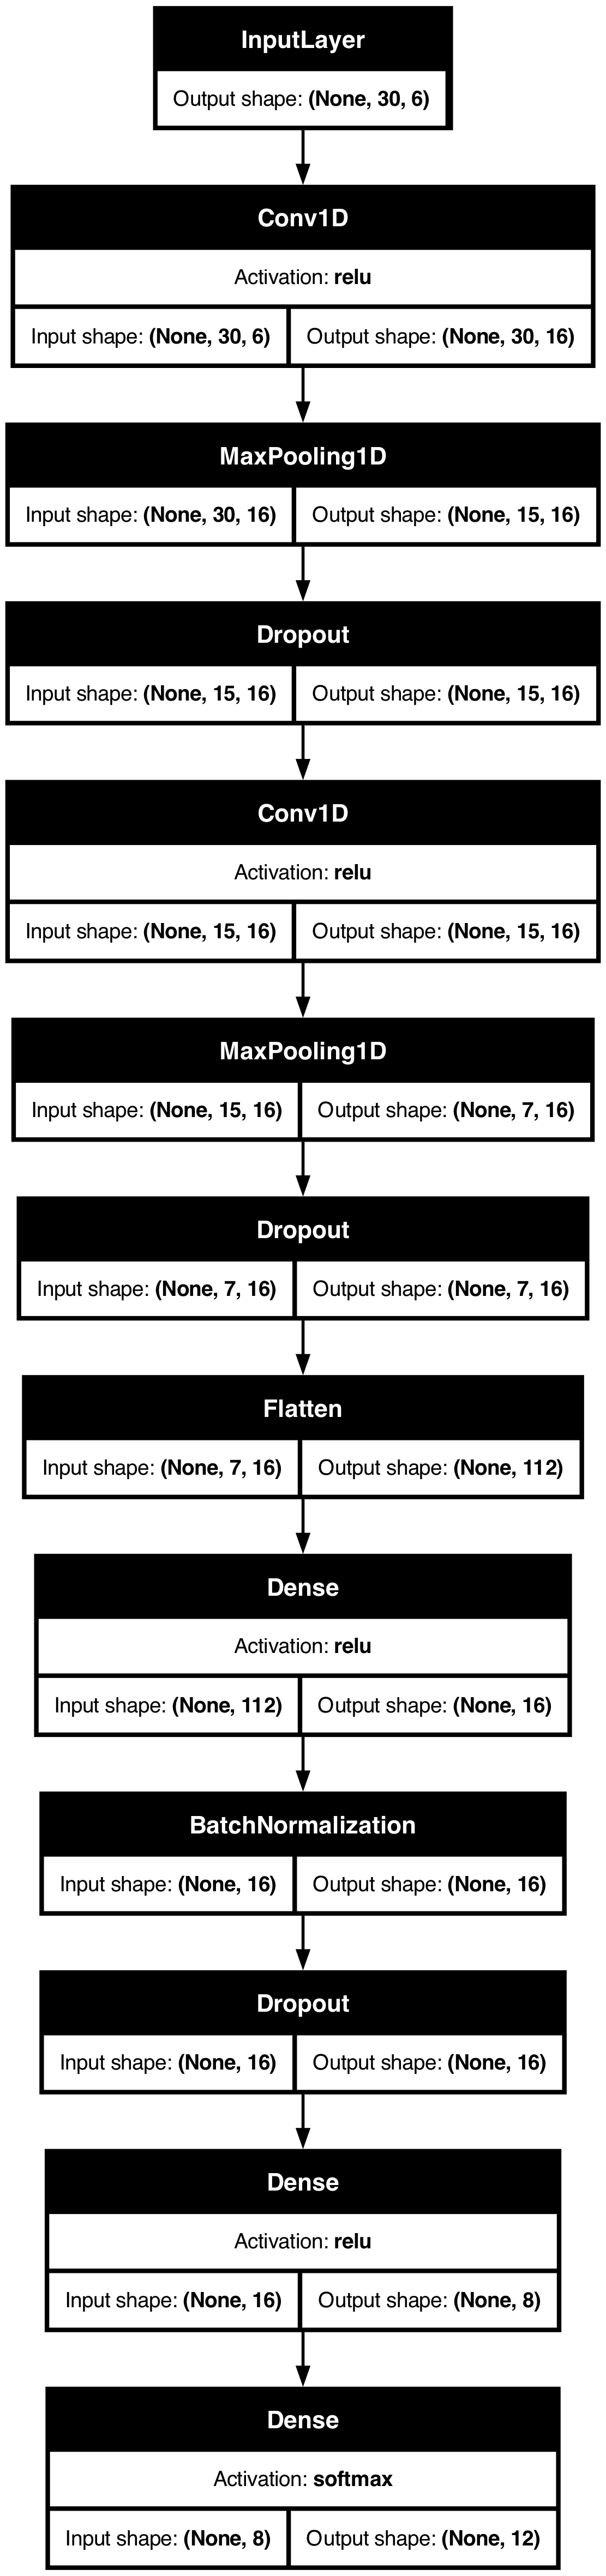

In [18]:
# 다시 modelling

# 모델 정의
input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.3)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.3)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(16, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(8, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [19]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(X_train_seq, y_train_seq, epochs=100, 
                        validation_data=(X_val_seq, y_val_seq), batch_size=32, 
                        callbacks=early_stopping_cb, 
                        verbose=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_29902/1973919818.py
Epoch 1/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 536s 4ms/step - accuracy: 0.4468 - loss: 1.7341 - val_accuracy: 0.4492 - val_loss: 1.7205
Epoch 2/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 553s 4ms/step - accuracy: 0.4496 - loss: 1.7205 - val_accuracy: 0.4492 - val_loss: 1.7205
Epoch 3/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 516s 4ms/step - accuracy: 0.4493 - loss: 1.7205 - val_accuracy: 0.4492 - val_loss: 1.7205
Epoch 4/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 535s 4ms/step - accuracy: 0.4491 - loss: 1.7202 - val_accuracy: 0.4492 - val_loss: 1.7203
Epoch 5/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 541s 4ms/step - accuracy: 0.4495 - loss: 1.7202 - val_accuracy: 0.4492 - val_loss: 1.7206
Epoch 6/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 559s 4ms/step - accuracy: 0.4492 - loss: 1.7204 - val_accuracy: 0.4492 - val_loss: 1.7203
Epoch 7/100
129226/129226 ━━━━━━━━━━━━━━━━━━━━ 504s 4ms/step - accuracy:

{'accuracy': [0.4489051103591919, 0.4492422342300415, 0.4492422342300415, 0.4492422342300415, 0.4492422342300415, 0.4492422342300415, 0.4492422342300415], 'loss': [1.7227540016174316, 1.7205822467803955, 1.7205156087875366, 1.7204639911651611, 1.7204209566116333, 1.7203967571258545, 1.7203928232192993], 'val_accuracy': [0.4492451548576355, 0.4492451548576355, 0.4492451548576355, 0.4492451548576355, 0.4492451548576355, 0.4492451548576355, 0.4492451548576355], 'val_loss': [1.7204757928848267, 1.7205089330673218, 1.7205396890640259, 1.720284342765808, 1.7205548286437988, 1.720315933227539, 1.7203565835952759]}


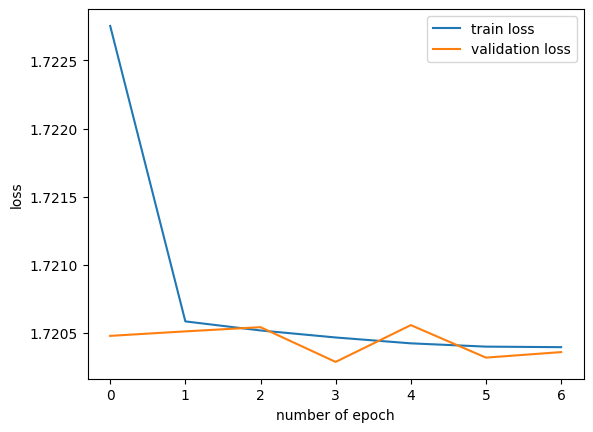

In [21]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [22]:
# evaluate

model.evaluate(X_val_seq, y_val_seq)

32306/32306 ━━━━━━━━━━━━━━━━━━━━ 20s 616us/step - accuracy: 0.4497 - loss: 1.7196


[1.720284342765808, 0.4492451548576355]

In [27]:
y_val_pred = model.predict(X_val_seq)
y_test_pred = model.predict(X_test_seq)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val_seq, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test_seq, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val_seq, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test_seq, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

32306/32306 ━━━━━━━━━━━━━━━━━━━━ 22s 670us/step
40383/40383 ━━━━━━━━━━━━━━━━━━━━ 30s 735us/step
- validation data confusion matrix -

[[     0      0      0      0      0      0 191543      0      0      0
       0      0]
 [     0      0      0      0      0      0  46616      0      0      0
       0      0]
 [     0      0      0      0      0      0  40773      0      0      0
       0      0]
 [     0      0      0      0      0      0  12195      0      0      0
       0      0]
 [     0      0      0      0      0      0  10761      0      0      0
       0      0]
 [     0      0      0      0      0      0 118948      0      0      0
       0      0]
 [     0      0      0      0      0      0 464422      0      0      0
       0      0]
 [     0      0      0      0      0      0  68623      0      0      0
       0      0]
 [     0      0      0      0      0      0  63030      0      0      0
       0      0]
 [     0      0      0      0      0      0   8929      0      0 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

- validation data report of classification -

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    191543
         1.0       0.00      0.00      0.00     46616
         2.0       0.00      0.00      0.00     40773
         3.0       0.00      0.00      0.00     12195
         4.0       0.00      0.00      0.00     10761
         5.0       0.00      0.00      0.00    118948
         6.0       0.45      1.00      0.62    464422
         7.0       0.00      0.00      0.00     68623
         8.0       0.00      0.00      0.00     63030
         9.0       0.00      0.00      0.00      8929
        10.0       0.00      0.00      0.00      6685
        11.0       0.00      0.00      0.00      1258

    accuracy                           0.45   1033783
   macro avg       0.04      0.08      0.05   1033783
weighted avg       0.20      0.45      0.28   1033783


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- test data report of classification -

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    239428
         1.0       0.00      0.00      0.00     58271
         2.0       0.00      0.00      0.00     50968
         3.0       0.00      0.00      0.00     15242
         4.0       0.00      0.00      0.00     13449
         5.0       0.00      0.00      0.00    148694
         6.0       0.45      1.00      0.62    580521
         7.0       0.00      0.00      0.00     85778
         8.0       0.00      0.00      0.00     78792
         9.0       0.00      0.00      0.00     11163
        10.0       0.00      0.00      0.00      8357
        11.0       0.00      0.00      0.00      1573

    accuracy                           0.45   1292236
   macro avg       0.04      0.08      0.05   1292236
weighted avg       0.20      0.45      0.28   1292236


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


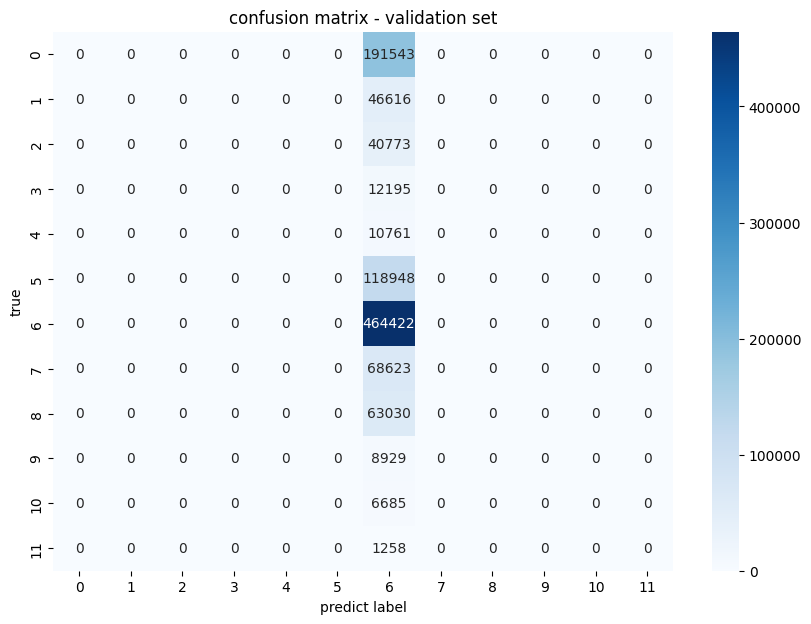

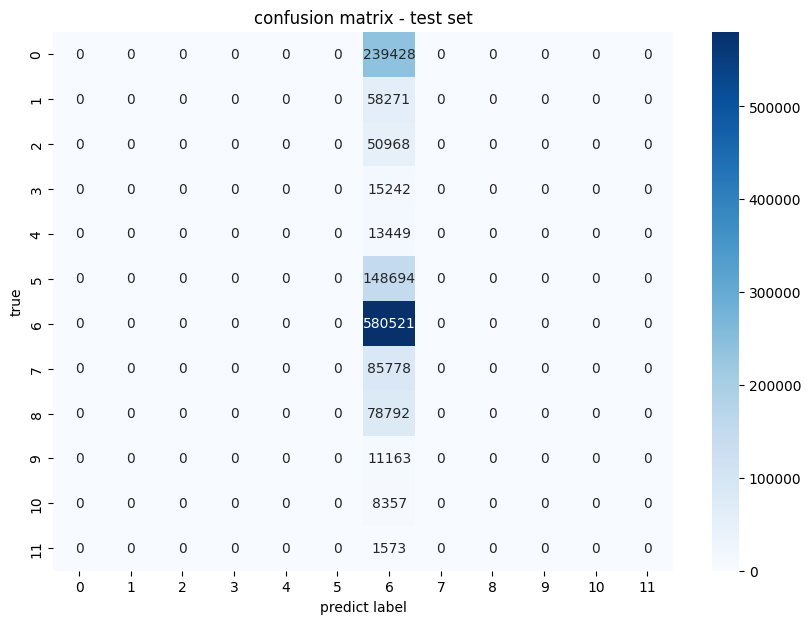

In [28]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - validation set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - test set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()